# Entropy Analysis

## Prolog

### Imports

In [12]:
from importlib import reload
import numpy as np          # Numeric Python
import scipy.stats as stats # Distribution functions and stuff
from scipy.optimize import minimize
import sqlite3 as sql       # To fetch data
import analysis             # Own analysis tools
reload(analysis);           # force reload of analysis, for it will be changed often

import seaborn as sb        # Plots
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = analysis.a4_dims

import random

import warnings
warnings.filterwarnings('ignore')

### Table Schemes

In [2]:
analysis.print_table_schemes(
    'data/k3-v500-r4.1.db',
    'experiment',
    'algorithm_run',
    'search_run',
    'dist_1',
    'dist_2'
)

TABLE experiment
  NAME                 DATA_TYPE            PRIMARY_KEY
  id                   INTEGER              1
  experiment_name      TEXT                 0

TABLE algorithm_run
  NAME                 DATA_TYPE            PRIMARY_KEY
  id                   INTEGER              1
  experiment_id        INTEGER              0
  solver               TEXT                 0
  formula_fname        TEXT                 0
  max_clause_len       INTEGER              0
  variables            INTEGER              0
  clauses              INTEGER              0
  cb                   REAL                 0
  time                 INTEGER              0
  sat                  BOOL                 0

TABLE search_run
  NAME                 DATA_TYPE            PRIMARY_KEY
  id                   INTEGER              1
  algorithm_run_id     INTEGER              0
  flips                INTEGER              0
  minimal_unsat        INTEGER              0
  last_unsat           INTEGER          

## Analysis

### Entropy Distribution

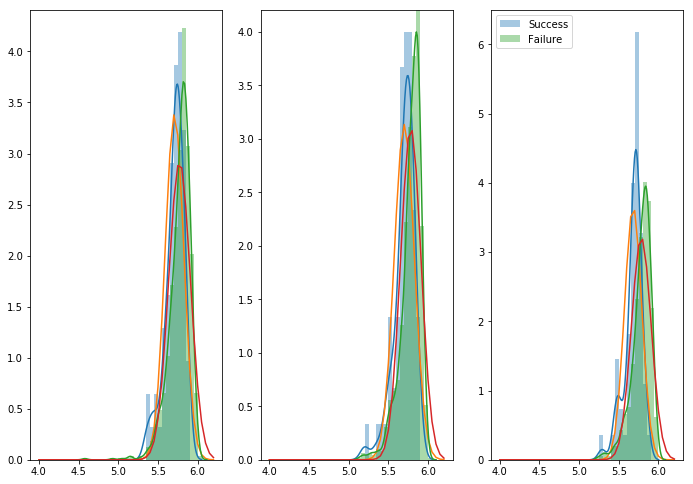

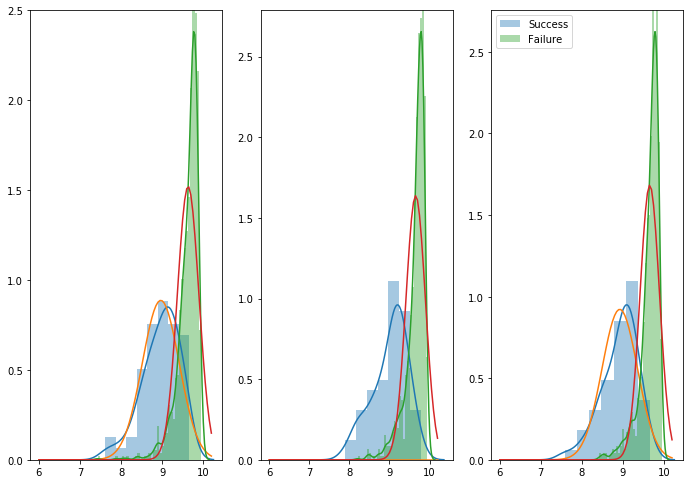

In [68]:
query = """
SELECT search_run.{}
FROM algorithm_run INNER JOIN search_run ON search_run.algorithm_run_id = algorithm_run.id
WHERE algorithm_run.experiment_id = ? AND search_run.last_unsat {}
"""
   
samples = 3

bins_1 = np.arange(4.0,6.25,0.05) 
bins_2 = np.arange(6.0,10.25,0.05)    
pdf = stats.norm.pdf
bounds = [(0.0001,None),(0.0001,None)]
theta_0 = lambda X: [np.average(X), np.var(X)]

with sql.connect('data/k3-v500-r4.2.db') as conn:
    c = conn.cursor()
    ids, = zip(*c.execute('SELECT id FROM experiment')) # Get experiment indices
    ids = random.sample(ids, samples)                   # Choose three experiments randomly
    
    
    XS_sat = [list(zip(*c.execute(query.format('h_1', '= 0'),(exp_id,))))[0] for exp_id in ids]
    
    YS_sat = [list(zip(*c.execute(query.format('h_2', '= 0'),(exp_id,))))[0] for exp_id in ids]
    
    XS_unsat = [list(zip(*c.execute(query.format('h_1', '> 0'),(exp_id,))))[0] for exp_id in ids]
    
    YS_unsat = [list(zip(*c.execute(query.format('h_2', '> 0'),(exp_id,))))[0] for exp_id in ids]


    figX, axesX = plt.subplots(1,samples)
    for i,X in enumerate(XS_sat):
        sb.distplot(X, label = 'Success', ax = axesX[i], hist=True, bins=bins_1)
        res = minimize(
            fun = lambda args: -analysis.log_likelihood(lambda x: pdf(x, *args), X),
            x0  = theta_0(X),
            bounds = bounds,
        )
        if res.success:
            loc, scale = res.x
            axesX[i].plot(bins_1, np.vectorize(lambda x: pdf(x, loc, scale))(bins_1))
        else:
            print(loc, scale)
                
        
    for i,X in enumerate(XS_unsat):
        sb.distplot(X, label = 'Failure', ax = axesX[i], hist=True, bins=bins_1)
        res = minimize(
            fun = lambda args: -analysis.log_likelihood(lambda x: pdf(x, *args), X),
            x0  = theta_0(X),
            bounds = bounds,
        )
        if res.success:
            loc, scale = res.x
            axesX[i].plot(bins_1, np.vectorize(lambda x: pdf(x, loc, scale))(bins_1))
        else:
            print(loc, scale)
    plt.legend()
        
    figY, axesY = plt.subplots(1,samples)
    for i,Y in enumerate(YS_sat):
        sb.distplot(Y, label = 'Success',ax = axesY[i], hist=True)
        res = minimize(
            fun = lambda args: -analysis.log_likelihood(lambda x: pdf(x, *args), Y),
            x0  = theta_0(Y),
            bounds = bounds,
        )
        if res.success:
            loc, scale = res.x
            axesY[i].plot(bins_2, np.vectorize(lambda x: pdf(x, loc, scale))(bins_2))
        else:
            print(loc, scale)
            
    for i,Y in enumerate(YS_unsat):
        sb.distplot(Y, label = 'Failure',ax = axesY[i], hist=True)  
        res = minimize(
            fun = lambda args: -analysis.log_likelihood(lambda x: pdf(x, *args), Y),
            x0  = theta_0(Y),
            bounds = bounds,
        )
        if res.success:
            loc, scale = res.x
            axesY[i].plot(bins_2, np.vectorize(lambda x: pdf(x, loc, scale))(bins_2))
        else:
            print(loc, scale)
    plt.legend()
    